In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
import random
import time
import collections
import warnings
from scipy.stats import pearsonr, spearmanr

%matplotlib inline

In [2]:
train_tcga_df = pd.read_csv('/Users/shruti/Documents/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('/Users/shruti/Documents/GitHub/Gene-compression-and-Cancer-type-classification/data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('/Users/shruti/Documents/GitHub/Gene-compression-and-Cancer-type-classification/data/tcga_sample_identifiers.tsv', header=0, sep='\t')

In [3]:
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,3430.0,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,6050.0,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,4930.0,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,3890.0,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,1930.0,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0


In [5]:
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,2730.0,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,4510.0,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,4420.0,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,5460.0,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,5200.0,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0


In [6]:
labels_tcga_df.head()

,sample_id,sample_type,cancer_type
0,TCGA-02-0047-01,Primary Solid Tumor,GBM
1,TCGA-02-0055-01,Primary Solid Tumor,GBM
2,TCGA-02-2483-01,Primary Solid Tumor,GBM
3,TCGA-02-2485-01,Primary Solid Tumor,GBM
4,TCGA-02-2486-01,Primary Solid Tumor,GBM


In [7]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

In [8]:
merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

In [40]:
train_tcga_df['cancer_type'] = merge_train
train_tcga_df.head()
train_tcga_df.shape

(9954, 16150)

In [41]:
test_tcga_df['cancer_type'] = merge_test
test_tcga_df.head()
test_tcga_df.shape

(1106, 16150)

In [195]:
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Function to approximate Keras `binary_crossentropy()`
    https://github.com/keras-team/keras/blob/e6c3f77b0b10b0d76778109a40d6d3282f1cadd0/keras/losses.py#L76
    Which is a wrapper for TensorFlow `sigmoid_cross_entropy_with_logits()`
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    An important step is to clip values of reconstruction
    https://github.com/keras-team/keras/blob/a3d160b9467c99cbb27f9aa0382c759f45c8ee66/keras/backend/tensorflow_backend.py#L3071
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))

In [196]:
def returnDf2(c_type):
    df2  = train_tcga_df.drop(['sample_id'], axis=1)

    fraction = collections.Counter(merge_train)[c_type]/len(merge_train)

    df2_0 = df2[df2.cancer_type!=c_type]
    df2_0.loc[:,"cancer_type"] = 0
    df2_0 = df2_0.sample(frac = fraction)

    df2_1 = df2[df2.cancer_type==c_type]
    df2_1.loc[:,"cancer_type"] = 1

    df2 = pd.concat([df2_0, df2_1])
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    return df2

In [197]:
def returnTest2(c_type):
    test2  = test_tcga_df.drop(['sample_id'], axis=1)

    fraction = collections.Counter(merge_test)[c_type]/len(merge_test)

    test2_0 = test2[test2.cancer_type!=c_type]
    test2_0.loc[:,"cancer_type"] = 0
    test2_0 = test2_0.sample(frac = fraction)

    test2_1 = test2[test2.cancer_type==c_type]
    test2_1.loc[:,"cancer_type"] = 1

    test2 = pd.concat([test2_0, test2_1])
    test2 = test2.astype('int')
    return test2

In [198]:
def runSVM(df2, test2):
    #first LR classifier with 16149 variables
    time_laps = []
    for i in range(4):
        start_time = time.time()
        clf = LogisticRegression(random_state=0).fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
        pred = clf.predict(test2.iloc[:,0:test2.shape[1]])
        accuracy = accuracy_score(test2.cancer_type,pred)
        laps = time.time() - start_time
        time_laps.append(laps)
    avg_time_laps = np.mean(time_laps)
    SVM_accuracy = accuracy
    SVM_computation_time = avg_time_laps
    return SVM_accuracy, SVM_computation_time

In [199]:
def compile_reconstruction(pca,ctype,k,test=False):
        """
        Compile reconstruction costs between input and algorithm reconstruction
        Arguments:
        Two dictionaries storing 1) reconstruction costs and 2) reconstructed
        matrix for each algorithm
        """
        
        
        if (test):
            input_df= pd.read_csv ('pca/input_test_{}.csv'.format(ctype))
            input_df = input_df.iloc[: , 1:]
            pca_df= pd.read_csv('pca/principal_comp_test_{}_{}.csv'.format(ctype,k))
            pca_df = pca_df.iloc[: , 1:]
            key = 'test'
        else:
            input_df= pd.read_csv('pca/input_train_{}.csv'.format(ctype))
            input_df = input_df.iloc[: , 1:]
            pca_df= pd.read_csv('pca/principal_comp_train_{}_{}.csv'.format(ctype,k))
            pca_df = pca_df.iloc[: , 1:]
            key= 'train'
        
        
        pca_reconstruct_mat = pca.inverse_transform(pca_df)
        
        reconstruct_mat = pd.DataFrame(pca_reconstruct_mat,
                                              index=input_df.index,
                                              columns=input_df.columns)
        reconstruct_mat.to_csv ('pca/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))


In [241]:
def returnPCA(df2, test2, ctype, k):
    warnings.filterwarnings("ignore")

    start_time = time.time()
    new = pd.concat([df2,test2],axis=0)
    standard = StandardScaler()
    
    result_train = standard.fit_transform(df2.iloc[:,0:df2.shape[1]])
    result_train = pd.DataFrame(result_train)
    result_train.to_csv ('pca/input_train_{}.csv'.format(ctype))
    
    result_test = standard.fit_transform(test2.iloc[:,0:test2.shape[1]])
    result_test = pd.DataFrame(result_test)
    result_test.to_csv ('pca/input_test_{}.csv'.format(ctype))
    n_comp= min(k, result_train.shape[0])

    # PCA calculation
    pca = PCA(n_components=n_comp)
    
    # PCA Model Fitting for Train Set
    principal_comp_train = pca.fit_transform(result_train)
    colnames = ['pca_{}'.format(x) for x in range(0, n_comp)]
    principal_comp_train = pd.DataFrame(principal_comp_train,
                               columns=colnames,index=result_train.index)
    principal_comp_train.to_csv ('pca/principal_comp_train_{}_{}.csv'.format(ctype,k))
    pca_weights_train = pd.DataFrame(pca.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    pca_weights_train.to_csv ('pca/pca_weights_train_{}_{}.csv'.format(ctype,k))
    pca_time = time.time()-start_time
    
    # PCA Transform on the Test Set
    principal_comp_test = pca.transform(result_test)
    principal_comp_test = pd.DataFrame(principal_comp_test,
                               columns=colnames,index=result_test.index)
    principal_comp_test.to_csv ('pca/principal_comp_test_{}_{}.csv'.format(ctype,k))

    
    # variance calculation
    explanation = pca.explained_variance_ratio_
    cummulative_sum = explanation.cumsum()
    
    # compile reconstruction 
    compile_reconstruction(pca,ctype,k)
    compile_reconstruction(pca,ctype,k,test=True)
    
    return principal_comp_train, principal_comp_test, explanation, cummulative_sum, pca_time



In [201]:
def prepPCAClassifier(df2, test2, principal_comp_train, principal_comp_test):
    #y_col = pd.concat([df2.cancer_type,test2.cancer_type],axis=0)
    train_y= df2.cancer_type
    test_y=  test2.cancer_type
    
    train_x= principal_comp_train.iloc[:,0:principal_comp_train.shape[1]]
    test_x = principal_comp_test.iloc[:,0:principal_comp_test.shape[1]]
    
    #train_x,test_x,train_y,test_y = train_test_split(principal_comp.iloc[:,0:principal_comp.shape[1]],principal_comp.cancer_type,test_size=0.25)
    return train_x,test_x,train_y,test_y

In [202]:
# LR model after PCA

def PCAClassifier(train_x, train_y, test_x, test_y):
    com_time_laps=[]
    for i in range(4):
        start_time = time.time()
        clf2 = LogisticRegression(random_state=0).fit(train_x,train_y)
        pred= clf2.predict(test_x)
        accuracy = accuracy_score(pred,test_y)
        precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
        time_laps_after_pca = time.time() - start_time
        com_time_laps.append(time_laps_after_pca)
        lis = [accuracy,np.mean(com_time_laps)]
    return accuracy, np.mean(com_time_laps), precision, recall, f1score

In [227]:
c_type_list = collections.Counter(merge_train)
# c_type_list = ['LUAD', 'LGG', 'PRAD', 'STAD']
#c_type_list = ['DLBC']
cols = ['cancer_type', 'Full-data acc.', 'Full-data comp. time', 'PCA components', 'PCA calc. time', 'PCA explained variance', 'PCA acc.','Precision', 'Recall', 'F1Score']

results_df = pd.DataFrame(columns = cols)
i = 0
num_latent_space= [2,5,10,20,50,100,150,200]
# num_latent_space= [100,150,200]
for k in num_latent_space:
    for c_type in c_type_list:
        print(str(k) + ", " + c_type)
        # train_data
        df2 = returnDf2(c_type)
        #test data
        test2 = returnTest2(c_type)
        # run LR on Entire datasaet 
        accuracy, avg_time_laps = runSVM(df2, test2)
        
        # calculate PCA and reconstruction 
        principal_comp_train, principal_comp_test, explanation, cummulative_sum, pca_time\
        = returnPCA(df2, test2, c_type, k)
        
        # get train test split
        train_x,test_x,train_y,test_y = prepPCAClassifier(df2, test2, principal_comp_train, principal_comp_test)
        
        # run LR on principal components
        pca_acc, pca_time, precision, recall, f1score = PCAClassifier(train_x, train_y, test_x, test_y)
        
        results_df.loc[i] = [c_type, accuracy,avg_time_laps, principal_comp_test.shape[1],pca_time, cummulative_sum[len(cummulative_sum)-1], pca_acc,precision, recall, f1score ]
        i = i+1


100, BRCA
100, LUAD
100, DLBC
100, UCEC
100, SKCM
100, PRAD
100, HNSC
100, KIRP
100, CESC
100, THCA
100, KIRC
100, STAD
100, COAD
100, READ
100, LGG
100, MESO
100, LAML
100, BLCA
100, OV
100, LUSC
100, ACC
100, THYM
100, ESCA
100, PAAD
100, LIHC
100, SARC
100, GBM
100, TGCT
100, KICH
100, PCPG
100, UCS
100, UVM
100, CHOL
150, BRCA
150, LUAD
150, DLBC
150, UCEC
150, SKCM
150, PRAD
150, HNSC
150, KIRP
150, CESC
150, THCA
150, KIRC
150, STAD
150, COAD
150, READ
150, LGG
150, MESO
150, LAML
150, BLCA
150, OV
150, LUSC
150, ACC
150, THYM
150, ESCA
150, PAAD
150, LIHC
150, SARC
150, GBM
150, TGCT
150, KICH
150, PCPG
150, UCS
150, UVM
150, CHOL
200, BRCA
200, LUAD
200, DLBC
200, UCEC
200, SKCM
200, PRAD
200, HNSC
200, KIRP
200, CESC
200, THCA
200, KIRC
200, STAD
200, COAD
200, READ
200, LGG
200, MESO
200, LAML
200, BLCA
200, OV
200, LUSC
200, ACC
200, THYM
200, ESCA
200, PAAD
200, LIHC
200, SARC
200, GBM
200, TGCT
200, KICH
200, PCPG
200, UCS
200, UVM
200, CHOL


In [232]:
results_df
# results_df.to_csv ('pca/pca_accuracy_results_100_150_200.csv')

,cancer_type,Full-data acc.,Full-data comp. time,PCA components,PCA calc. time,PCA explained variance,PCA acc.,Precision,Recall,F1Score
0,BRCA,0.978355,2.212981,100,0.044279,0.626864,0.987013,"[0.9732142857142857, 1.0]","[1.0, 0.9754098360655737]","[0.9864253393665159, 0.9875518672199171]"
1,LUAD,0.972973,1.417653,100,0.030333,0.672908,0.963964,"[0.9464285714285714, 0.9818181818181818]","[0.9814814814814815, 0.9473684210526315]","[0.9636363636363636, 0.9642857142857142]"
2,DLBC,1.000000,0.277988,10,0.007248,0.520825,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
3,UCEC,0.963303,1.345738,100,0.035586,0.670474,0.954128,"[0.9444444444444444, 0.9636363636363636]","[0.9622641509433962, 0.9464285714285714]","[0.9532710280373832, 0.9549549549549549]"
4,SKCM,1.000000,0.954509,92,0.032513,0.668717,0.989130,"[0.9782608695652174, 1.0]","[1.0, 0.9787234042553191]","[0.989010989010989, 0.989247311827957]"
...,...,...,...,...,...,...,...,...,...,...
94,KICH,0.900000,0.310718,20,0.026840,0.586358,0.950000,"[0.9090909090909091, 1.0]","[1.0, 0.9]","[0.9523809523809523, 0.9473684210526316]"
95,PCPG,1.000000,0.407170,38,0.009845,0.624141,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
96,UCS,1.000000,0.246003,12,0.010004,0.460111,0.916667,"[0.8571428571428571, 1.0]","[1.0, 0.8333333333333334]","[0.923076923076923, 0.9090909090909091]"
97,UVM,1.000000,0.285436,16,0.005278,0.591982,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"


In [365]:
# concatenate data frames from both the runs
df1= pd.read_csv ('pca/pca_accuracy_results.csv')
df1 = df1.iloc[: , 1:]
df2= pd.read_csv ('pca/pca_accuracy_results_100_150_200.csv')
df2 = df2.iloc[: , 1:]
frames = [df1, df2]
result = pd.concat(frames)
result.to_csv ('pca/pca_accuracy_results_total.csv')

In [382]:
# overall results
result
result.loc[result['PCA components']==int(50)]


,cancer_type,Full-data acc.,Full-data comp. time,PCA components,PCA calc. time,PCA explained variance,PCA acc.,Precision,Recall,F1Score
132,BRCA,0.969697,2.268541,50,0.049487,0.535452,0.982684,[0.97297297 0.99166667],[0.99082569 0.97540984],[0.98181818 0.98347107]
133,LUAD,0.972973,1.306194,50,0.032947,0.567587,0.981982,[0.98148148 0.98245614],[0.98148148 0.98245614],[0.98148148 0.98245614]
134,DLBC,1.000000,0.279839,50,0.006095,0.906791,1.000000,[1. 1.],[1. 1.],[1. 1.]
135,UCEC,0.963303,1.286587,50,0.019075,0.573108,0.944954,[0.92727273 0.96296296],[0.96226415 0.92857143],[0.94444444 0.94545455]
136,SKCM,0.967391,1.014347,50,0.023424,0.567711,0.967391,[1. 0.94],[0.93333333 1. ],[0.96551724 0.96907216]
137,PRAD,1.000000,0.766039,50,0.013655,0.613221,1.000000,[1. 1.],[1. 1.],[1. 1.]
138,HNSC,0.981651,1.269112,50,0.025558,0.586941,0.944954,[0.92727273 0.96296296],[0.96226415 0.92857143],[0.94444444 0.94545455]
139,KIRP,0.984615,0.841395,50,0.017394,0.629588,0.984615,[0.96969697 1. ],[1. 0.96969697],[0.98461538 0.98461538]
140,CESC,0.868852,1.452271,50,0.018080,0.589872,0.868852,[0.92307692 0.82857143],[0.8 0.93548387],[0.85714286 0.87878788]
141,THCA,1.000000,0.717865,50,0.026145,0.631488,1.000000,[1. 1.],[1. 1.],[1. 1.]


# Metrics Evaluation

In [246]:
# metrics evaluation 

def calc_reconstruct_loss(k,ctype,test= False): 
    if test:
        key='test'
    else:
        key= 'train'
    input_df= pd.read_csv ('pca/input_{}_{}.csv'.format(key,ctype))
    input_df = input_df.iloc[: , 1:]
    reconstruct_mat= pd.read_csv ('pca/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))
    reconstruct_mat = reconstruct_mat.iloc[: , 1:]
    
    loss = np.sum((input_df - reconstruct_mat) ** 2, axis=1).mean()
    
#     pca_recon_loss = approx_keras_binary_cross_entropy(reconstruct_mat, input_df,k)
    
    return loss
    

In [381]:
num_latent_space= [2,5,10,20,50,100,150,200]

#testing loss
k_loss =[]
class_wise_loss=[]

for k in num_latent_space:
    print(k)
    class_loss=[]
    for c_type in c_type_list:
        #mse loss
        loss=calc_reconstruct_loss(k,c_type,test=True)
        class_loss.append(loss)
    class_wise_loss.append(class_loss)
    k_loss.append(np.mean(class_loss))
print(np.array(k_loss).shape)   
print(np.array(class_wise_loss).shape)

2
5
10
20
50
100
150
200
(8,)
(8, 33)


In [393]:
num_latent_space= [2,5,10,20,50,100,150,200]

#training loss
k_loss_train =[]
class_wise_loss_train=[]

for k in num_latent_space:
    print(k)
    class_loss=[]
    for c_type in c_type_list:
        #mse loss
        loss=calc_reconstruct_loss(k,c_type)
        class_loss.append(loss)
    class_wise_loss_train.append(class_loss)
    k_loss_train.append(np.mean(class_loss))
print(np.array(k_loss_train).shape)   
print(np.array(class_wise_loss_train).shape)

2


KeyboardInterrupt: 

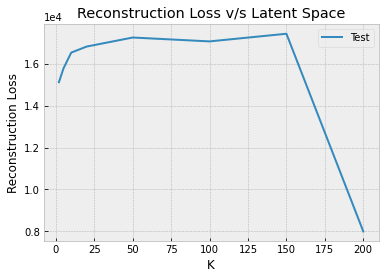

In [394]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, k_loss, label = "Test")

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '/Users/shruti/Documents/GitHub/Gene-compression-and-Cancer-type-classification/figure/reconstuction_pca'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Reconstruction Loss')

plt.title('Reconstruction Loss v/s Latent Space')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(path)
plt.legend()
plt.show()


No handles with labels found to put in legend.


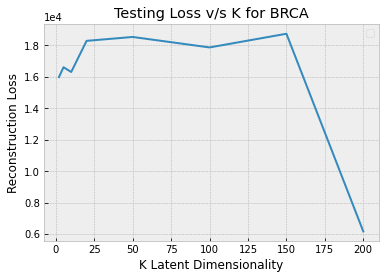

No handles with labels found to put in legend.


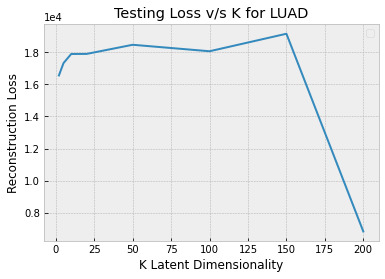

No handles with labels found to put in legend.


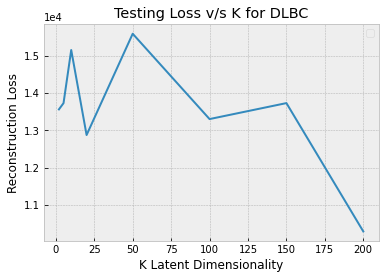

No handles with labels found to put in legend.


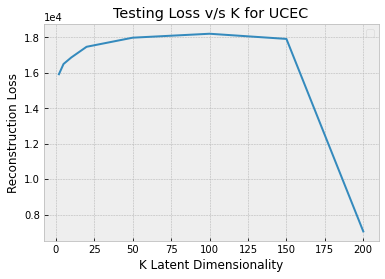

No handles with labels found to put in legend.


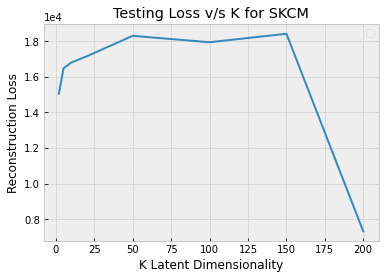

No handles with labels found to put in legend.


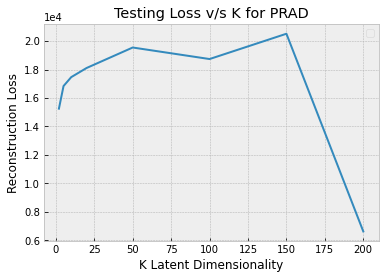

No handles with labels found to put in legend.


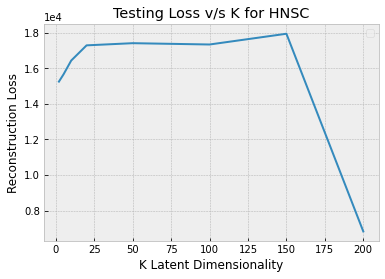

No handles with labels found to put in legend.


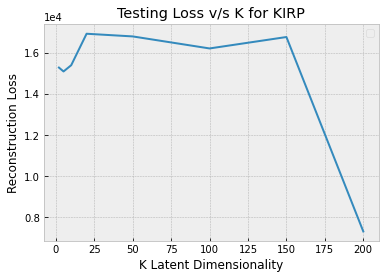

No handles with labels found to put in legend.


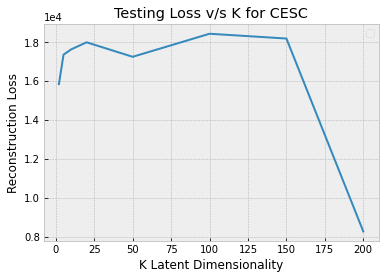

No handles with labels found to put in legend.


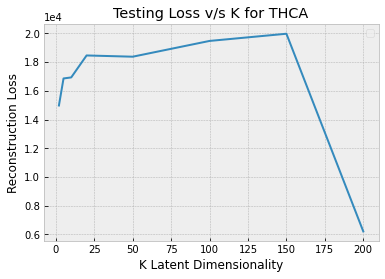

No handles with labels found to put in legend.


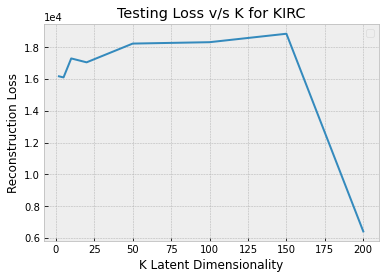

No handles with labels found to put in legend.


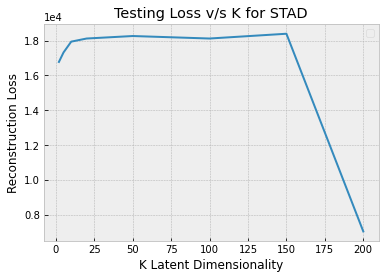

No handles with labels found to put in legend.


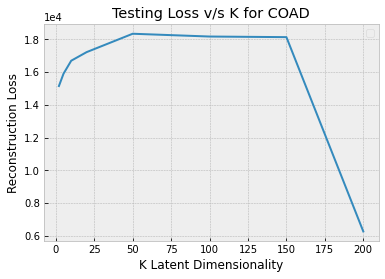

No handles with labels found to put in legend.


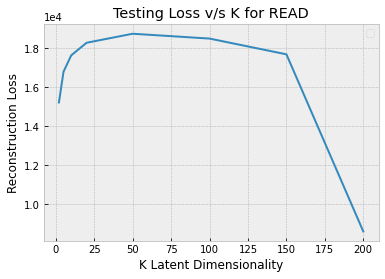

No handles with labels found to put in legend.


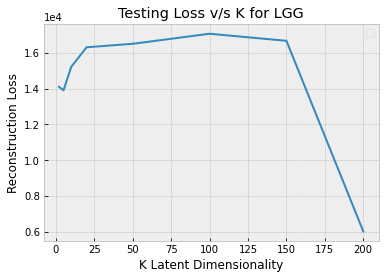

No handles with labels found to put in legend.


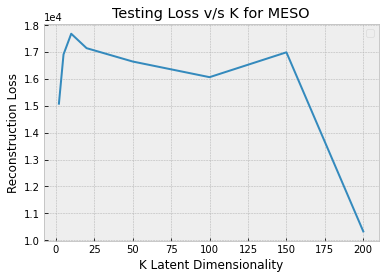

No handles with labels found to put in legend.


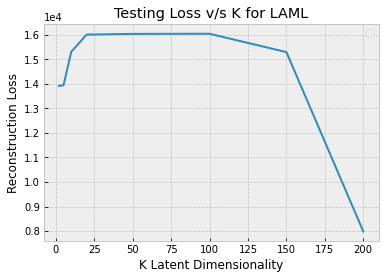

No handles with labels found to put in legend.


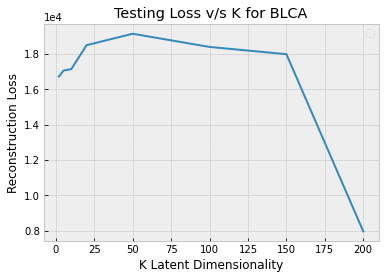

No handles with labels found to put in legend.


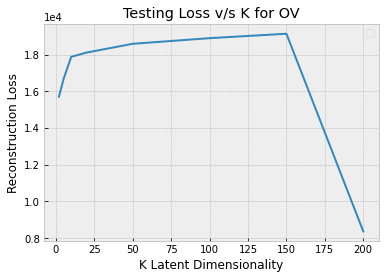

No handles with labels found to put in legend.


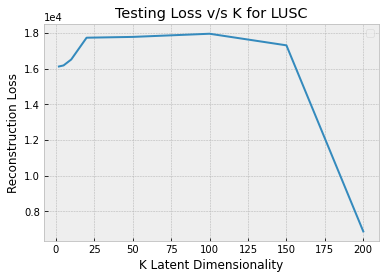

No handles with labels found to put in legend.


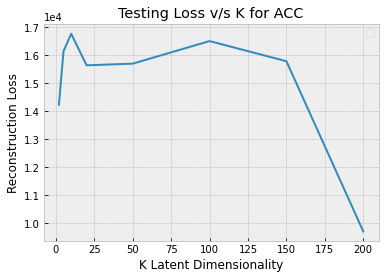

No handles with labels found to put in legend.


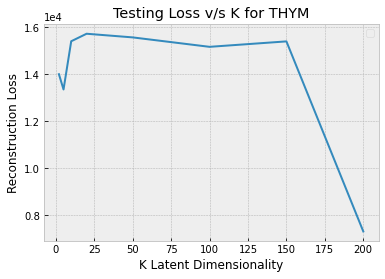

No handles with labels found to put in legend.


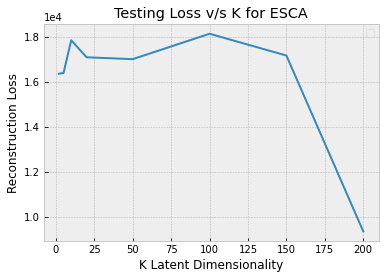

No handles with labels found to put in legend.


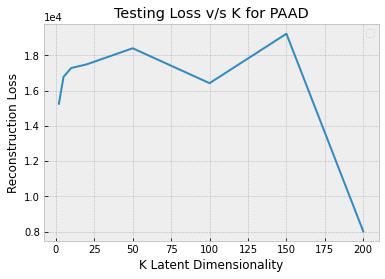

No handles with labels found to put in legend.


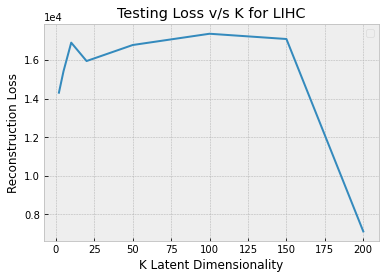

No handles with labels found to put in legend.


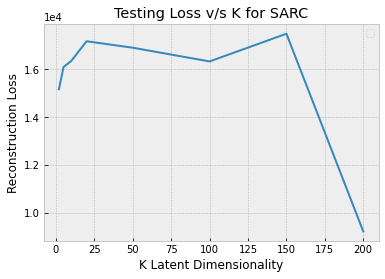

No handles with labels found to put in legend.


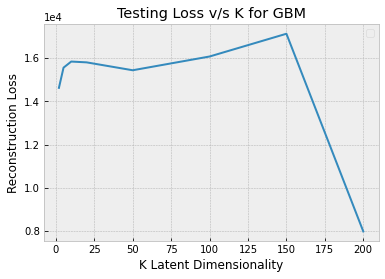

No handles with labels found to put in legend.


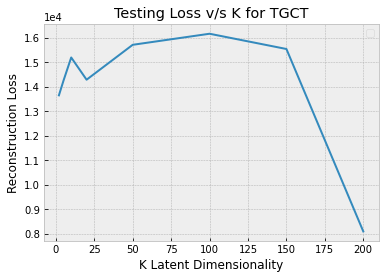

No handles with labels found to put in legend.


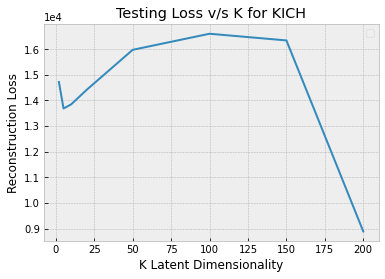

No handles with labels found to put in legend.


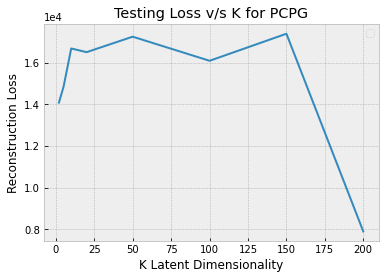

No handles with labels found to put in legend.


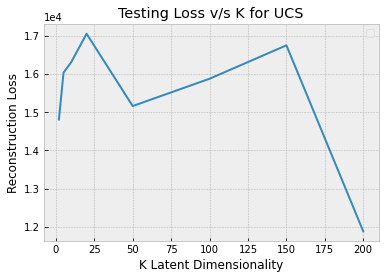

No handles with labels found to put in legend.


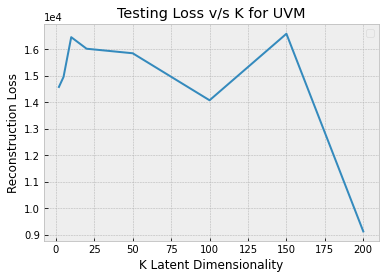

No handles with labels found to put in legend.


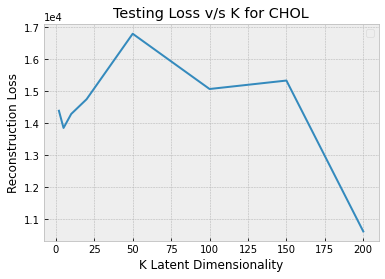

In [397]:
# plot class wise reconstruction loss graph 
# clean_labels_for_class_wise_plot=['UCEC','SKCM','HNSC','THCA']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_loss=np.array(class_wise_loss)
# class_wise_loss_train=np.array(class_wise_loss_train)
for ctype in range(len(c_type_list)):
    
    
    k_loss= class_wise_loss[:,ctype]
    plt.plot(num_latent_space, k_loss)


    # plt.plot(x2, y2, label = "Training")

    # naming the x axis
    plt.xlabel('K Latent Dimensionality')
    # naming the y axis
    plt.ylabel('Reconstruction Loss')
    # giving a title to my graph
    plt.title('Testing Loss v/s K for {}'.format(label[ctype]))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


    plt.legend()
    plt.show()

#

Selected ctype - 

For Reconstruction Loss with decent looking graph -

3,7,9,12,13,16,18,19

In [278]:
def calc_pearson(k, ctype, test= False):
    
    if test:
        key='test'
    else:
        key= 'train'
        
    input_df= pd.read_csv ('pca/input_{}_{}.csv'.format(key,ctype))
    input_df = input_df.iloc[: , 1:]
    reconstruct_mat= pd.read_csv ('pca/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))
    reconstruct_mat = reconstruct_mat.iloc[: , 1:]
    
    r = [pearsonr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]
    
    return r
    

In [348]:
# calculate test pearson correlation values
num_latent_space= [2,5,10,20,50,100,150,200]

#testing correlation values
k_pearson =[]
class_wise_pearson=[]

for k in num_latent_space:
    print(k)
    class_corr=[]
    for c_type in c_type_list:
        #mse loss
        pearson=calc_pearson(k,c_type,test=True)
        class_corr.append(pearson)
        
    class_wise_pearson.append(class_corr)
    
print(np.array(class_wise_pearson).shape)


2
5
10
20
50
100
150
200
(8, 33)


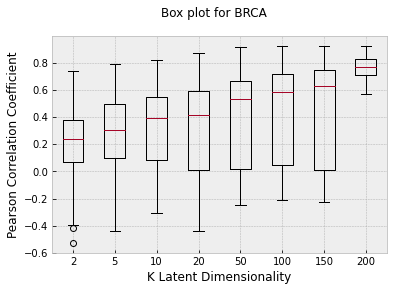

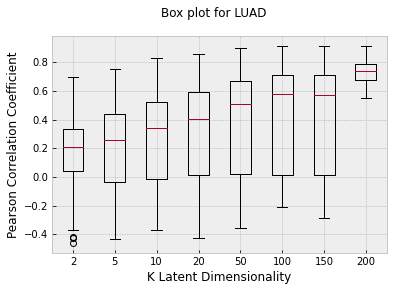

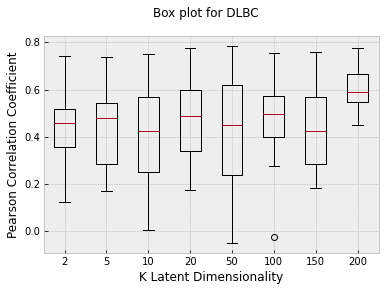

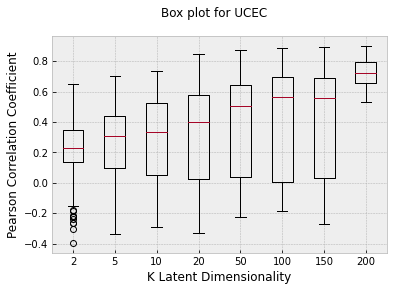

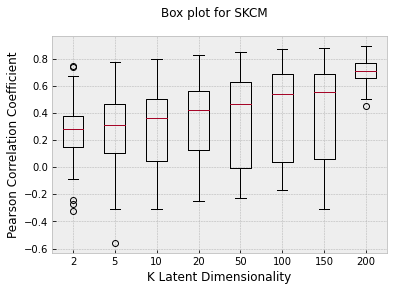

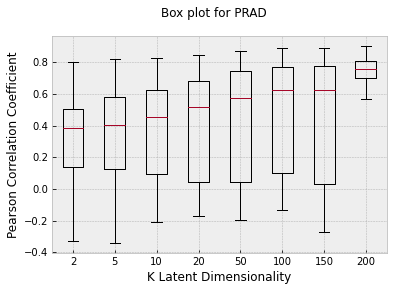

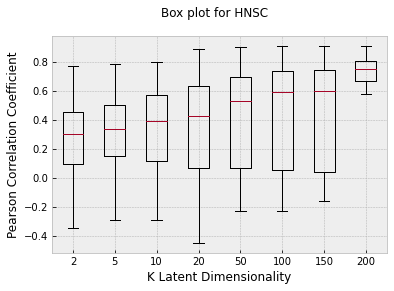

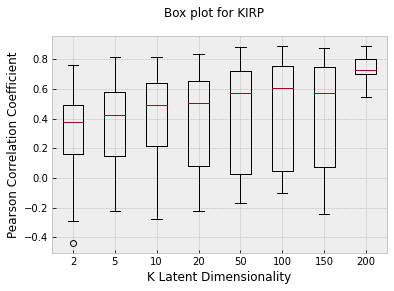

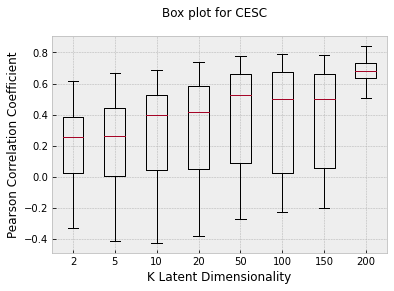

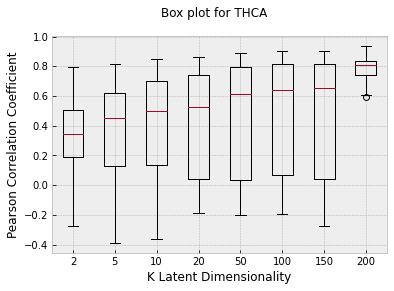

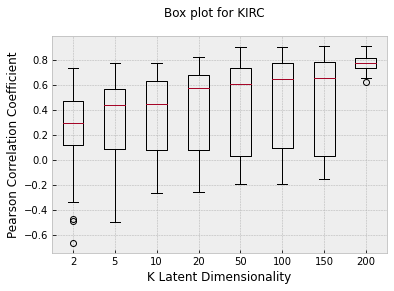

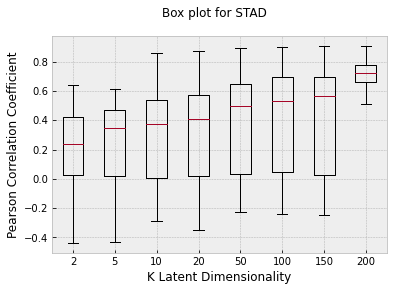

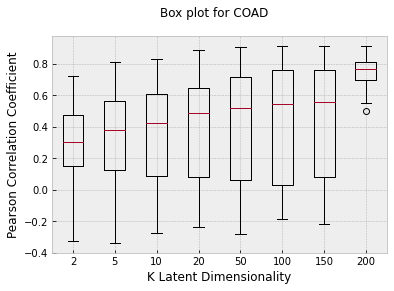

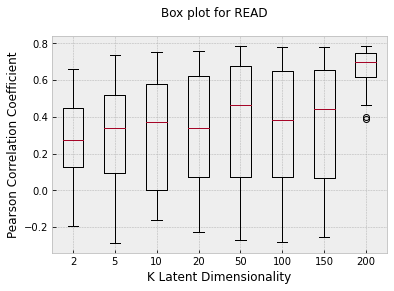

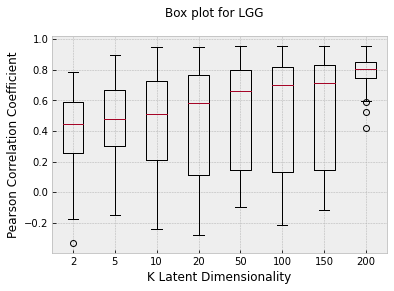

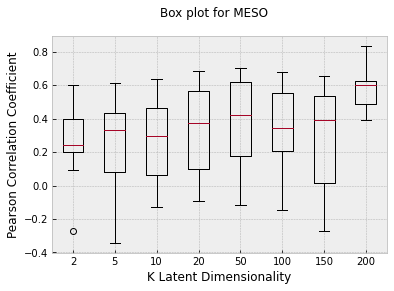

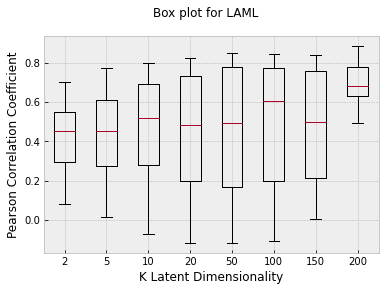

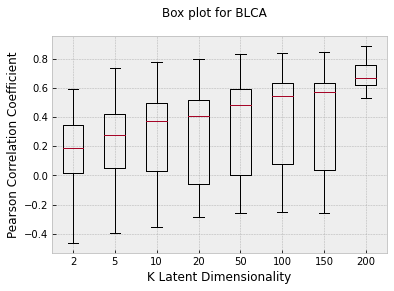

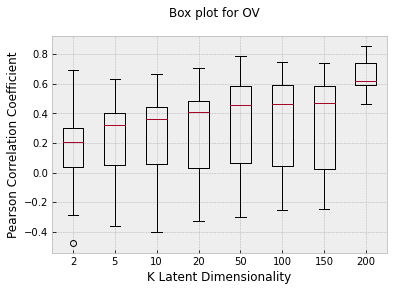

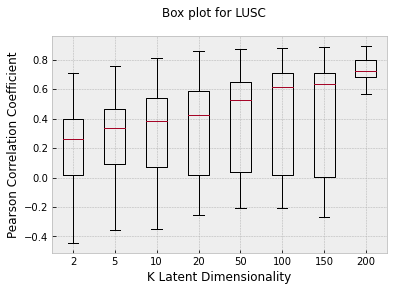

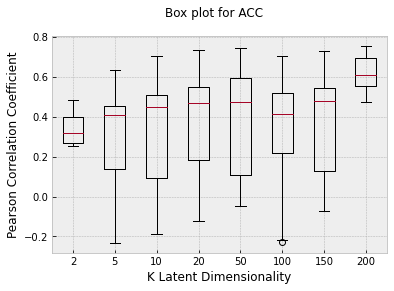

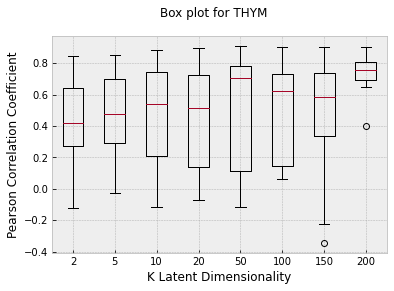

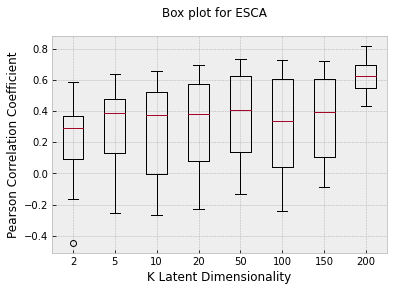

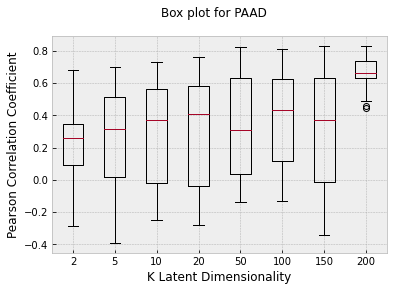

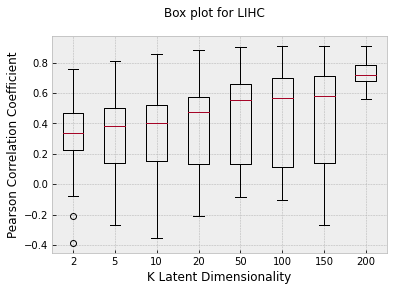

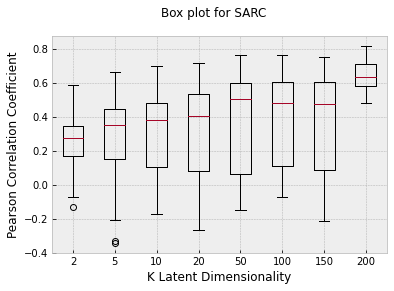

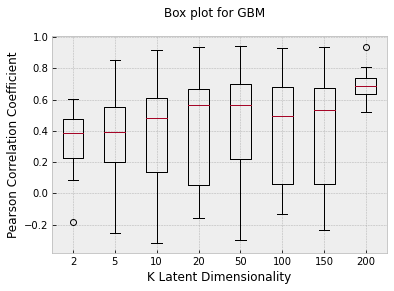

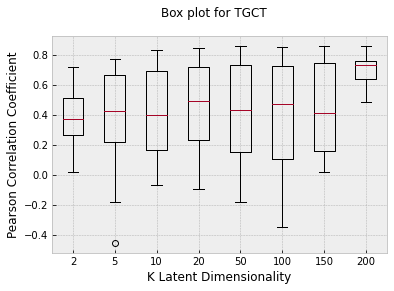

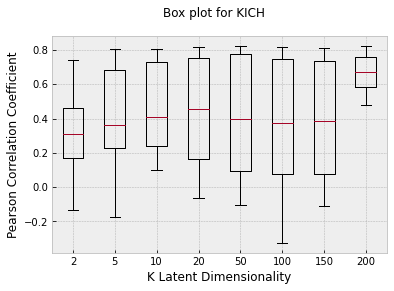

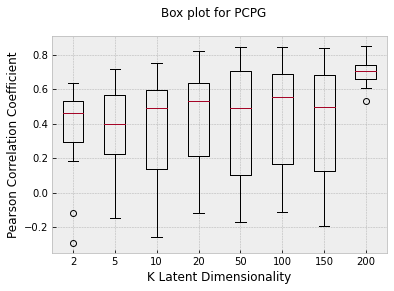

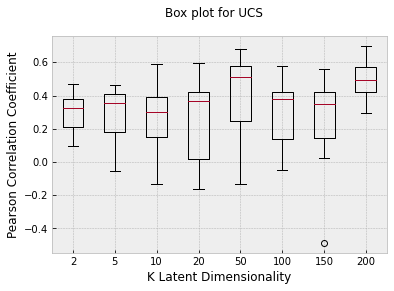

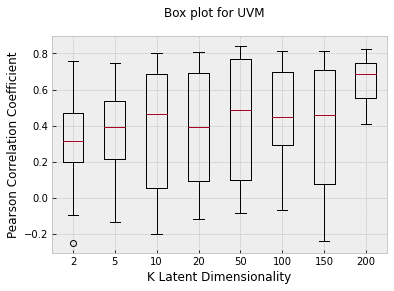

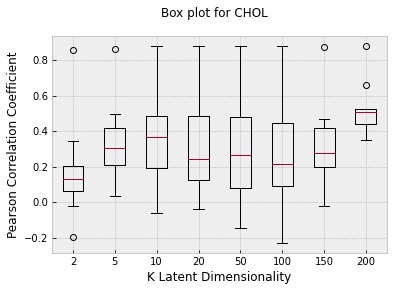

In [399]:
# plot class wise pearson correlation graph 
# clean_labels_for_good_plot= ['BRCA','BLCA','LUSC','THCA']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_pearson=np.array(class_wise_pearson)

num_latent_space=np.array(num_latent_space)
c_pearson=[]

for j in range(0,len(c_type_list)):
    c_pearson=[]
    for i in range(0,len(num_latent_space)):
        a=class_wise_pearson[i][j]
        c_pearson.append(a)
        
    # plot the box plot of the calculated pearson values
    c_pearson= np.array(c_pearson)
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+ label[j]) 
    ax.set_xlabel('K Latent Dimensionality') 
    ax.set_ylabel('Pearson Correlation Coefficient') 
    ax.boxplot(np.transpose(c_pearson), labels= num_latent_space) 
    #     fig.savefig(pearson_path)
    #     fig.clear(True) 
    

# Classes with good correlation values - 
BRCA, THCA, KIRC, STAD, LUSC, LGG, COAD

2-200

In [ ]:
# box plot for entire dataset Pearson Coefficient 



In [374]:
def calc_spearman(k, ctype, test= False):
    
    if test:
        key='test'
    else:
        key= 'train'
        
    input_df= pd.read_csv ('pca/input_{}_{}.csv'.format(key,ctype))
    input_df = input_df.iloc[: , 1:]
    reconstruct_mat= pd.read_csv ('pca/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))
    reconstruct_mat = reconstruct_mat.iloc[: , 1:]

    s = [spearmanr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]
    
    return s
    

In [375]:
# calculate test spearman correlation values
num_latent_space= [2,5,10,20,50,100,150,200]

#testing correlation values
k_spearman =[]
class_wise_spearman=[]

for k in num_latent_space:
    print(k)
    class_corr=[]
    for c_type in c_type_list:
        #mse loss
        spearman=calc_spearman(k,c_type,test=True)
        class_corr.append(spearman)
        
    class_wise_spearman.append(class_corr)
    
print(np.array(class_wise_spearman).shape)


2
5
10
20
50
100
150
200
(8, 33)


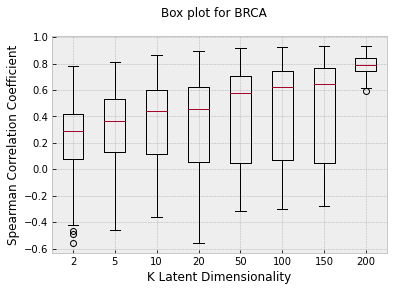

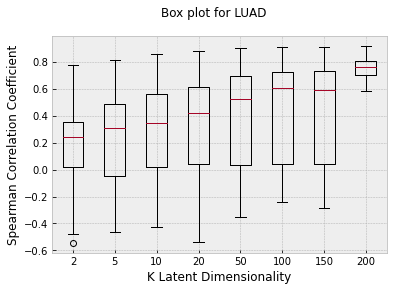

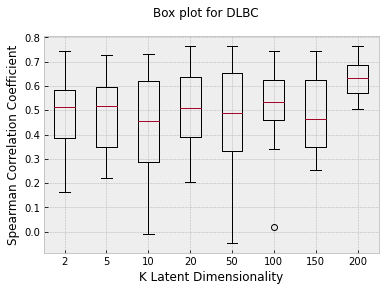

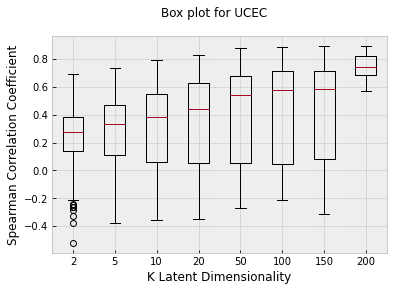

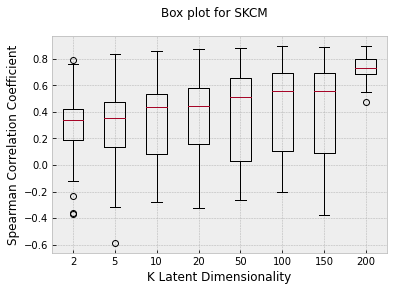

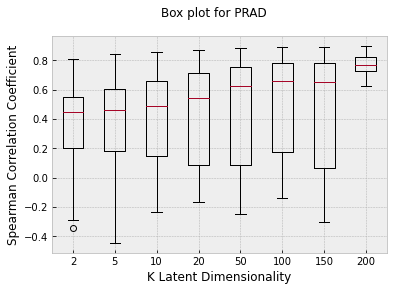

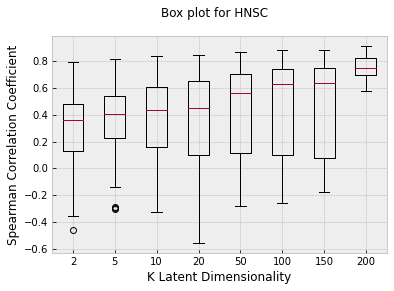

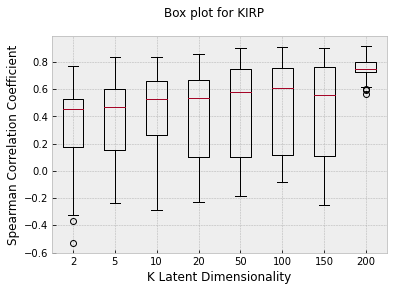

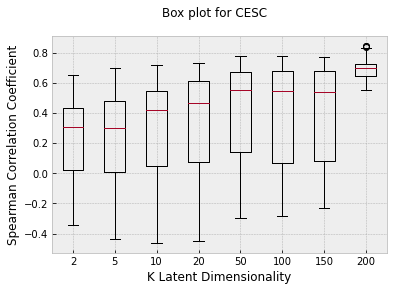

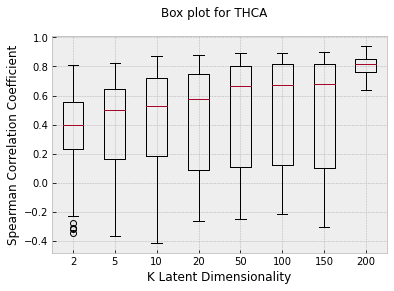

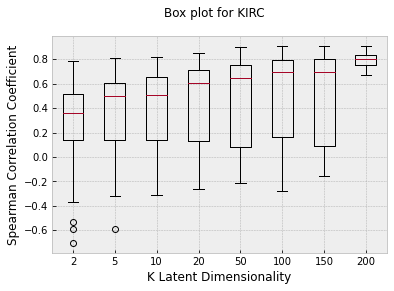

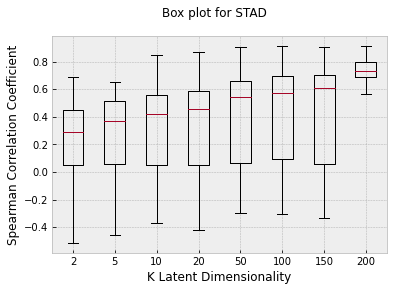

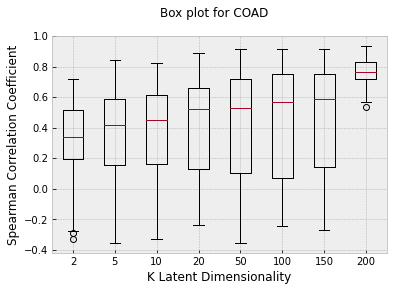

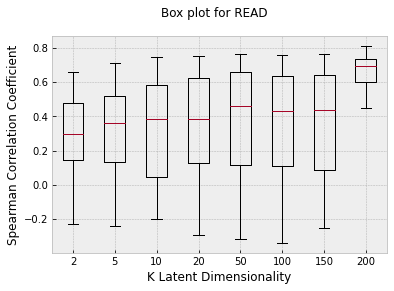

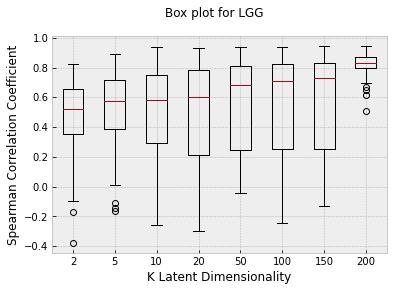

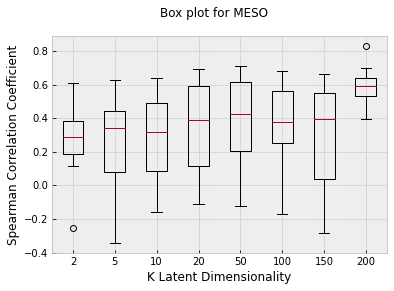

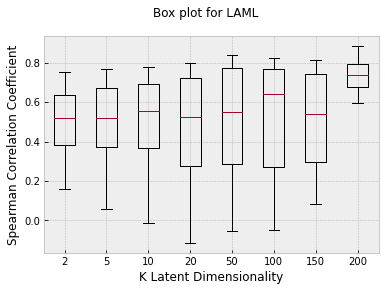

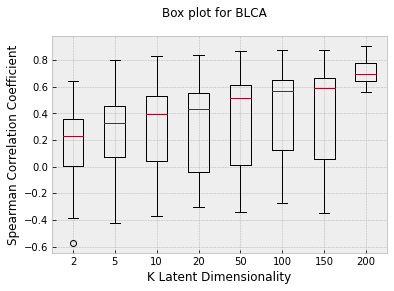

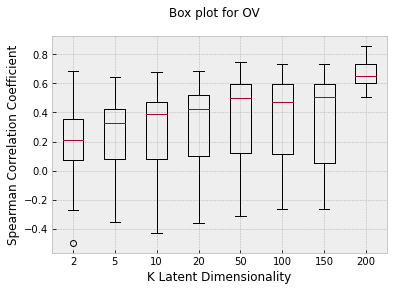

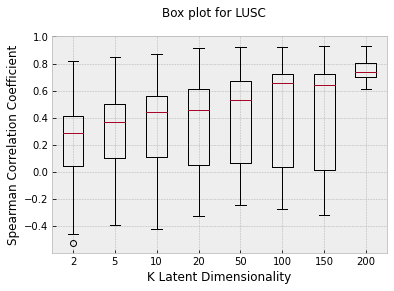

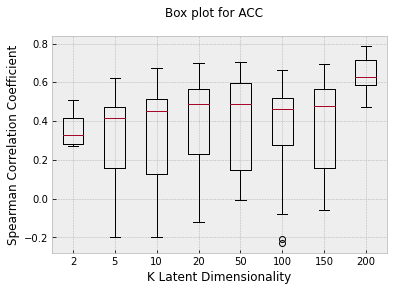

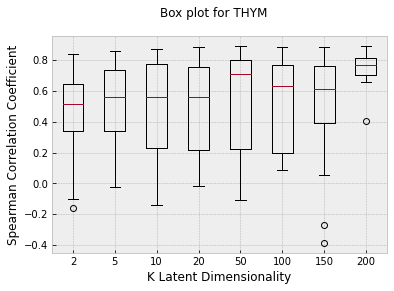

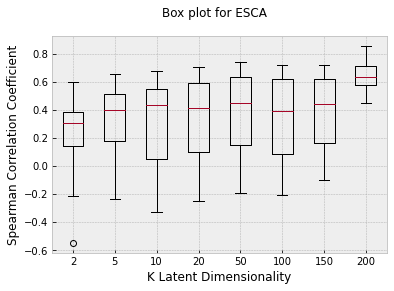

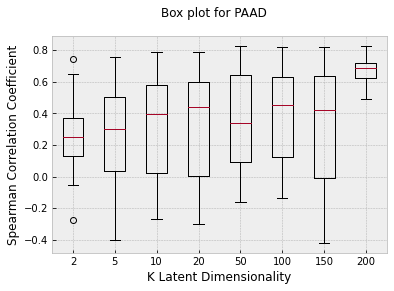

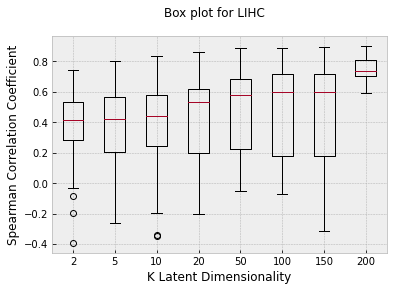

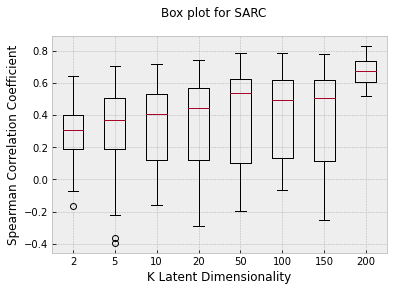

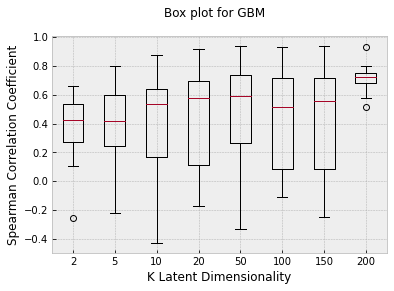

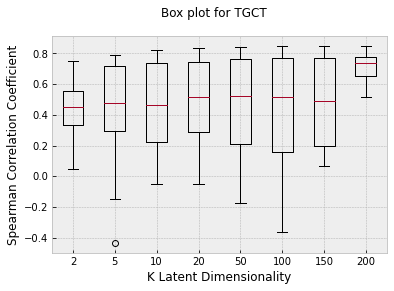

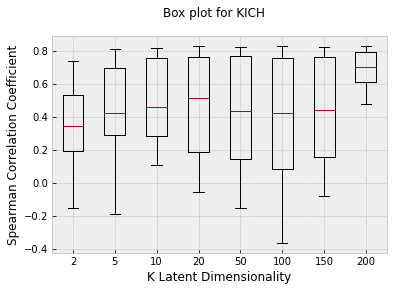

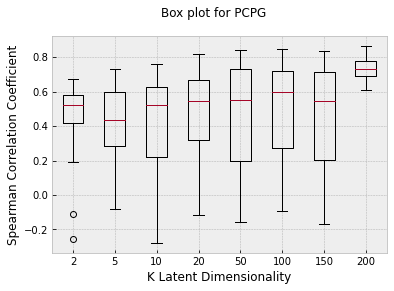

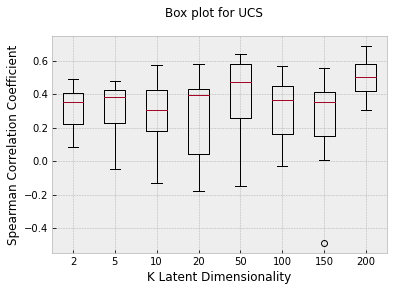

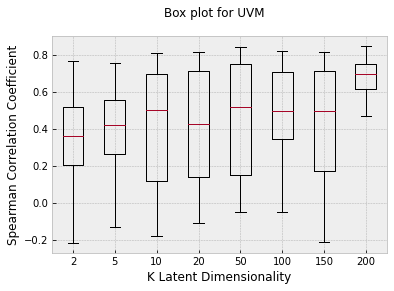

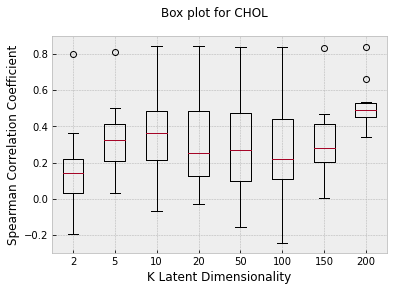

In [400]:
# plot class wise spearman correlation graph 
# clean_labels_for_good_plot= ['BRCA','BLCA','LUSC','THCA']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_spearman=np.array(class_wise_spearman)

num_latent_space=np.array(num_latent_space)
c_spearman=[]

for j in range(0,len(c_type_list)):
    c_spearman=[]
    for i in range(0,len(num_latent_space)):
        a=class_wise_spearman[i][j]
        c_spearman.append(a)
        
    # plot the box plot of the calculated pearson values
    c_spearman= np.array(c_spearman)
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+ label[j]) 
    ax.set_xlabel('K Latent Dimensionality') 
    ax.set_ylabel('Spearman Correlation Coefficient') 
    ax.boxplot(np.transpose(c_spearman), labels= num_latent_space) 
    #     fig.savefig(pearson_path)
    #     fig.clear(True) 
    

In [35]:
#2 4 10 16 25 50 80 100 200